This notebook can be run on mybinder: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgricad-gitlab.univ-grenoble-alpes.fr%2Fchatelaf%2Fconference-ia/master?urlpath=lab/tree/notebooks/1c_model_assesment/)

# Validation
In this notebook, we will apply and optimize several algorithms on the *Digits* dataset. This is used to illustrate  cross validation principles

### $k$ fold Cross Validation Algorithm

`Input`: input variables $X$ (dimension $n \times p$), responses $y$ (dimension n), number of folds $k$

`Divide` randomly the set $\{1, 2, ..., n\}$ in $k$ subsets (i.e., folds) of roughly equal sizes (e.g., size equals to the integer part of $n/k$ with a little smaller last part if $n$ is not a multiple of $k$) denoted as $F_1,\ldots,F_{k}$

`for i=1 to k:`
  * `Form` the validation set $(X_{val}, y_{val})$ where the indexes of the $X$ and $y$ variables belongs to the $i$th fold $F_i$
  * `Form` the training set $(X_{train}, y_{train})$  where the indexes of the $X$ and $y$ variables belongs to all the folds except $F_i$
  * `Train` the algorithm/model on the training set $(X_{train}, y_{train})$
  * `Apply` the resulting prediction rule on the input  $X_{val}$ of the validation set
  * `Compute` the error rate on the validation set based on the predictions and the true responses $y_{val}$

`Output`: the average error rate computed over all the $k$ folds

In [1]:
from sklearn.datasets import load_digits, load_iris
# Load digits
X, y = load_digits(return_X_y=True) # load_iris(return_X_y=True)
print(X.shape)
print(X.max())

(1797, 64)
16.0


# Visualization of the digits data set
The data set is made available *by NIST to extract normalized bitmaps of handwritten digits from a preprinted form. From a total of 43 people, 30 contributed to the training set and different 13 to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of 4x4 and the number of on pixels are counted in each block. This generates an input matrix of 8x8 where each element is an integer in the range 0..16* (https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits)

It is possible to visualize the data by reshaping correctly each sample:

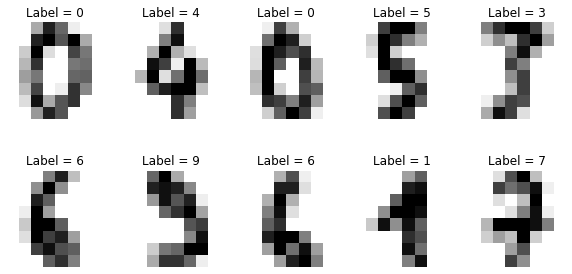

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot the first element
plt.figure(figsize=(10,5) )
plt.subplot(2, 5, 1)
plt.axis('off')
plt.imshow(X[0,:].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("Label = {}".format(y[0]))

# Plot the hundredth element
ith= 100
for ith in range(100,109):
    plt.subplot(2, 5, ith-98)
    plt.axis('off')
    plt.imshow(X[ith,:].reshape(8,8), plt.cm.gray_r, interpolation='nearest')
    plt.title("Label = {}".format(y[ith]))
plt.show()

## Classification framework
Two steps are required
- Model selection, i.e. find the optimal hyperparemeters,
- Model assessement, i.e. validate the model on unseen data.

As said in introduction, scikit-learn offers convenient and generic functions to achieve these steps.  In this labworks, an example is given for the nearest-neighbors classifier (KNeighborsClassifier) (http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). But it can be extended for any algorithm in scikit-learn, up to a correct definition of the hyperparameters.

In [3]:
import scipy as sp
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

# Standardize data
sc = MinMaxScaler()
X = sc.fit_transform(X) # Scale data between 0 and 1

# Split the data -> test_size=0.20 means we keep 80% of the data for training and 20% for validation
# The stratification ensures that the proportion of each class from the orginal data is preserved in the train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)

With distance based methods (s.t. k-NN or kernel methods), it is a good practice to standardize feature remove dynamics effect. Here we rescaled each feature between 0 and 1.

We use [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html) strategy to select the optimal set of hyperparameters.

We can plot the correct classification rate function of the hyperparameters. It is important to check if our search values are correct.

## Evaluation of k-NN classifier
Again, using scikit-learn generic function, it is possible with few lines of code to run all the experiments.

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Afficher les performances correspondantes
score = 'accuracy' #correct classification rate
param_grid = {'n_neighbors':[1, 3, 5, 7, 9, 11, 13, 15]}

clf = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv= 5, scoring=score)
clf.fit(X_train, y_train)

clf.best_estimator_  
    
print("Results for the cross-validation:")
print( clf.best_params_ )
for mean, std, params in zip(clf.cv_results_['mean_test_score'], # score moyen
clf.cv_results_['std_test_score'], # écart-type du score
clf.cv_results_['params'] # valeur de l'hyperparamètre
):
    print("\t%s = %0.3f (+/-%0.03f) for %r" % (score, # critère utilisé
                                            mean, # score moyen
                                            std * 2, # barre d'erreur
                                            params # hyperparamètre
                                            ) )
y_pred = clf.predict(X_test)
print("\nResults for the Test data set: %0.3f" % accuracy_score(y_test, y_pred) )


Results for the cross-validation:
{'n_neighbors': 3}
	accuracy = 0.985 (+/-0.014) for {'n_neighbors': 1}
	accuracy = 0.987 (+/-0.012) for {'n_neighbors': 3}
	accuracy = 0.983 (+/-0.017) for {'n_neighbors': 5}
	accuracy = 0.985 (+/-0.014) for {'n_neighbors': 7}
	accuracy = 0.981 (+/-0.012) for {'n_neighbors': 9}
	accuracy = 0.976 (+/-0.020) for {'n_neighbors': 11}
	accuracy = 0.974 (+/-0.028) for {'n_neighbors': 13}
	accuracy = 0.974 (+/-0.027) for {'n_neighbors': 15}

Results for the Test data set: 0.986


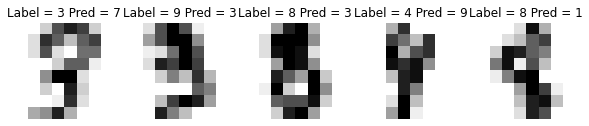

In [22]:
# Display some classification errors 
t = np.where(y_pred!=y_test)[0]
plt.figure(figsize=(10,5) )
for i, t_ in enumerate(t[:10]):
    plt.subplot(2, 5, i+1)
    plt.axis('off')
    plt.imshow(X_test[t_,:].reshape(8,8), cmap=plt.cm.gray_r)
    plt.title("Label = {} Pred = {}".format(y_test[t_],y_pred[t_]))

### Exercice
- Recall what are the benefits of cross-validation w.r.t the simple validation approach
- Apply the same CV procedure to the iris data set (see  and adapt notebook 
[`2_knn/N2_iris_knn.ipynb`](https://gricad-gitlab.univ-grenoble-alpes.fr/chatelaf/ml-sicom3a/-/blob/master/notebooks/2_knn/N2_iris_knn.ipynb)). Compare your results with the simple validation approach (fixed training and test set) used in [`2_knn/N2_iris_knn.ipynb`](https://gricad-gitlab.univ-grenoble-alpes.fr/chatelaf/ml-sicom3a/-/blob/master/notebooks/2_knn/N2_iris_knn.ipynb)